In [ ]:
#!pip install -r ../requirements.txt

In [ ]:
import os
import time
import random
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange 
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

## What is this notebook for?

This notebook showcases the loading of data, inference using our baseline model, evaluation of the predictions and dumping the predictions in the format required for upload on CodaLab.

# Data Analysis

## Examples

In [23]:
# Load the training data
train_data = pd.read_csv("data/train_data_SMM4H_2025_Task_1.csv")
dev_data = pd.read_csv("data/dev_data_SMM4H_2025_Task_1.csv")

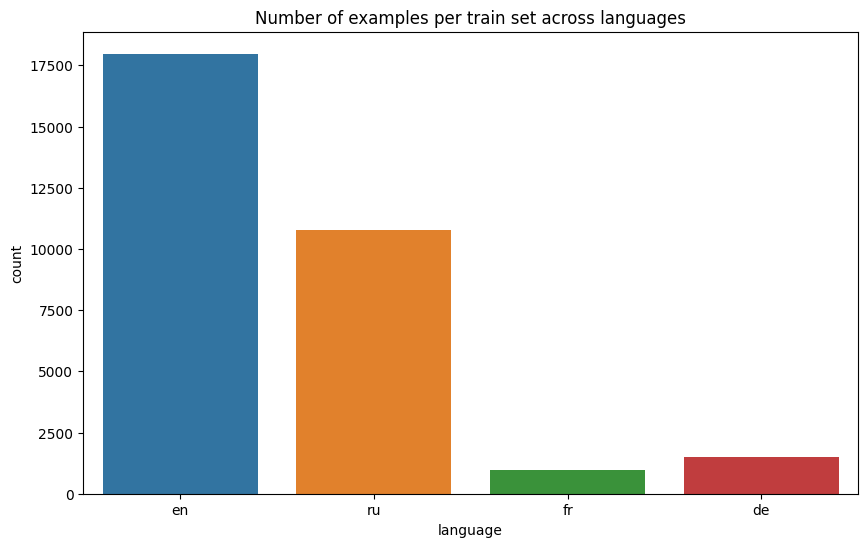

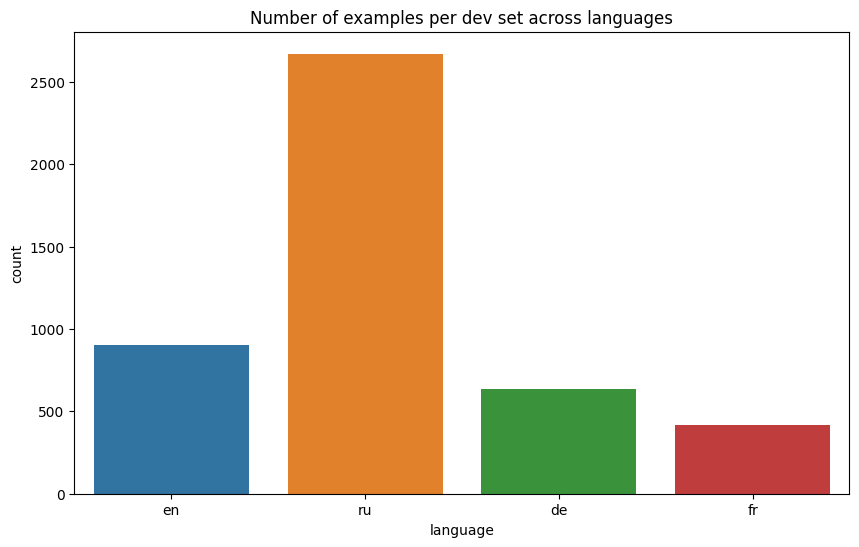

In [24]:
# plot the number of examples per train/dev set across languages

plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'])
plt.title("Number of examples per train set across languages")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'])
plt.title("Number of examples per dev set across languages")
plt.show()

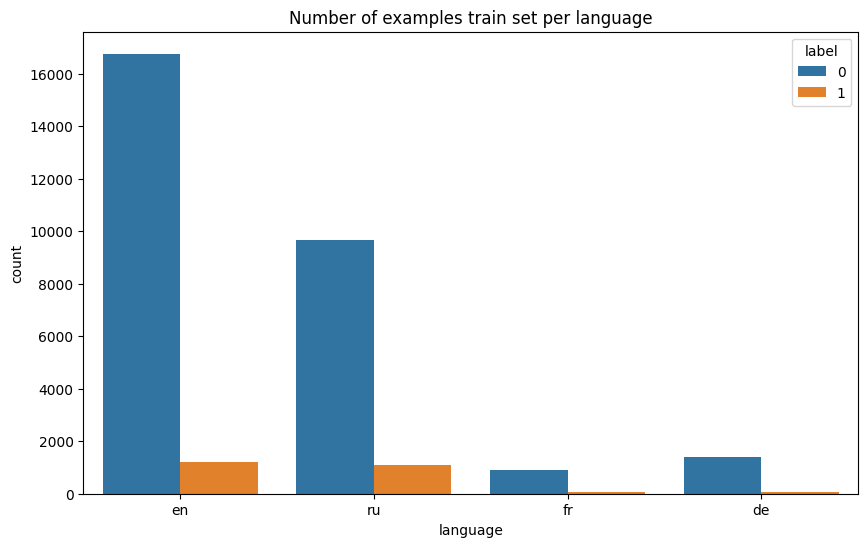

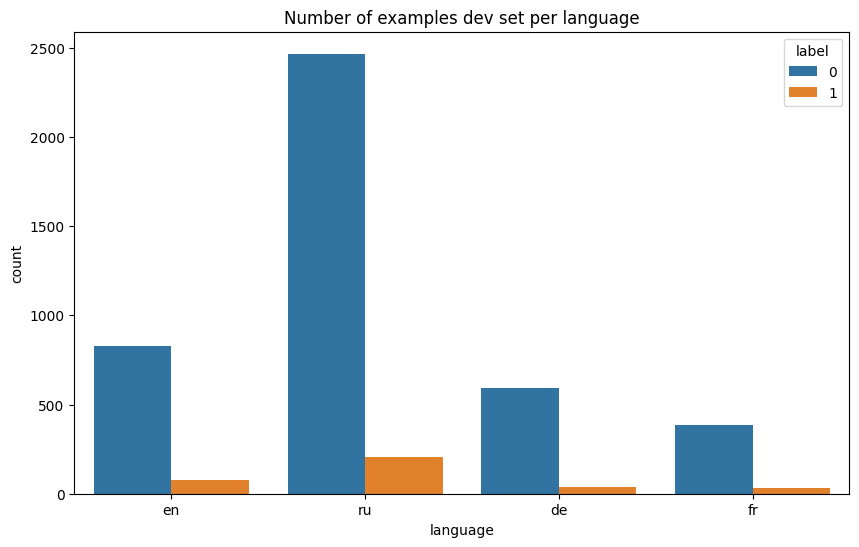

In [11]:
# plot the number of examples per train/dev per language
plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'], hue=train_data['label'])
plt.title("Number of examples train set per language")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'], hue=train_data['label'])
plt.title("Number of examples dev set per language")
plt.show()

In [25]:
# load the data as a pandas dataframe, show one random example of each language for each label
languages = train_data['language'].unique()
labels = train_data['label'].unique()
examples = []

for lang in languages:
    for label in labels:
        subset = train_data[(train_data['language'] == lang) & (train_data['label'] == label)]
        if not subset.empty:
            examples.append(subset.sample(1))

examples_df = pd.concat(examples)
print("Examples of each language and label:")
print(examples_df[['id', 'text', 'label', 'language']])

Examples of each language and label:
             id                                               text  label  \
9902   en_10964  @USER_________ if #avelox has hurt your liver,...      1   
2362    en_7765                I have to take my enbrel shot today      0   
13624  ru_12921  36. до перехода на АИП и другую схему горм. ле...      1   
9654   ru_10443  блин я не могу жрать метформин утром и вечером...      0   
4193     fr_689  Salut, Comme je suis très naturopathe, mais qu...      1   
18606    fr_468  N'existe-t-il pas une préparation combinée où ...      0   
3202    de_1396  Ich musste übrigens auch mal Kortison wegen me...      1   
3852     de_261  Hallo Mädels, entschuldigt wenn ich es so dire...      0   

      language  
9902        en  
2362        en  
13624       ru  
9654        ru  
4193        fr  
18606       fr  
3202        de  
3852        de  


## Type Distribution

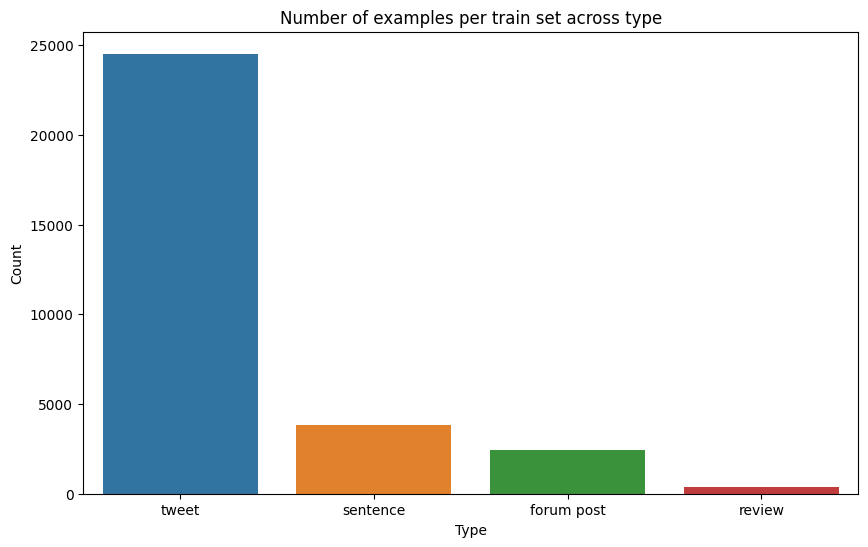

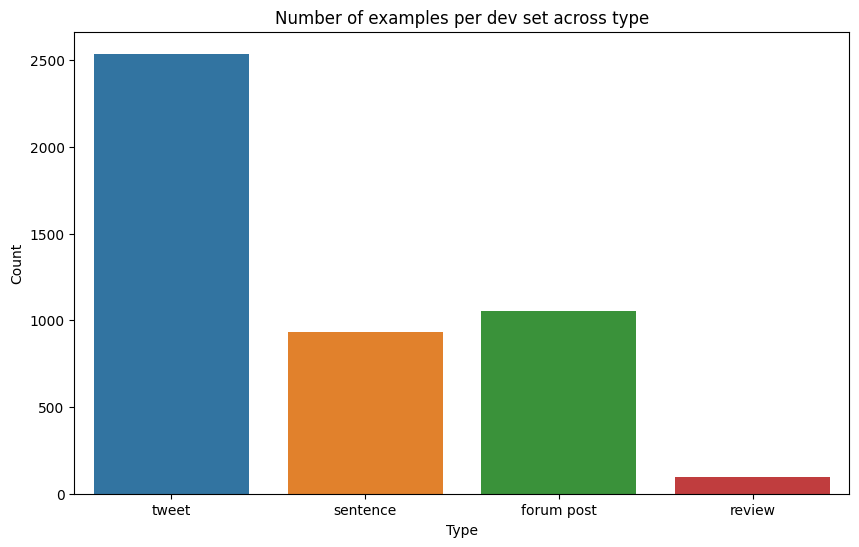

In [13]:
# Plot the number of examples per train/dev set across "type"

plt.figure(figsize=(10,6))
sns.countplot(x=train_data['type'])
plt.title("Number of examples per train set across type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['type'])
plt.title("Number of examples per dev set across type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

## Label Distribution

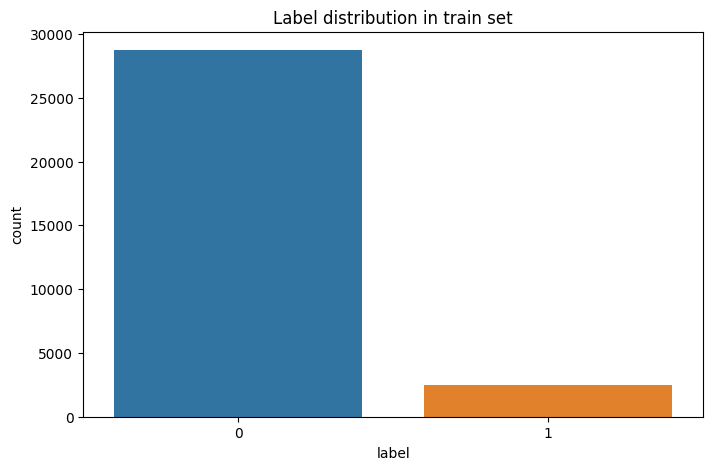

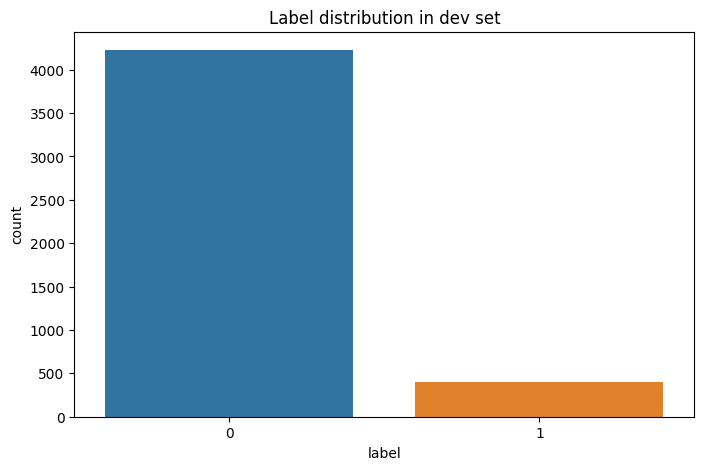

In [14]:
# plot the label distribution for the training and development sets (each one plot) across languages
plt.figure(figsize=(8,5))
sns.countplot(x=train_data['label'])
plt.title("Label distribution in train set")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x=dev_data['label'])
plt.title("Label distribution in dev set")
plt.show()

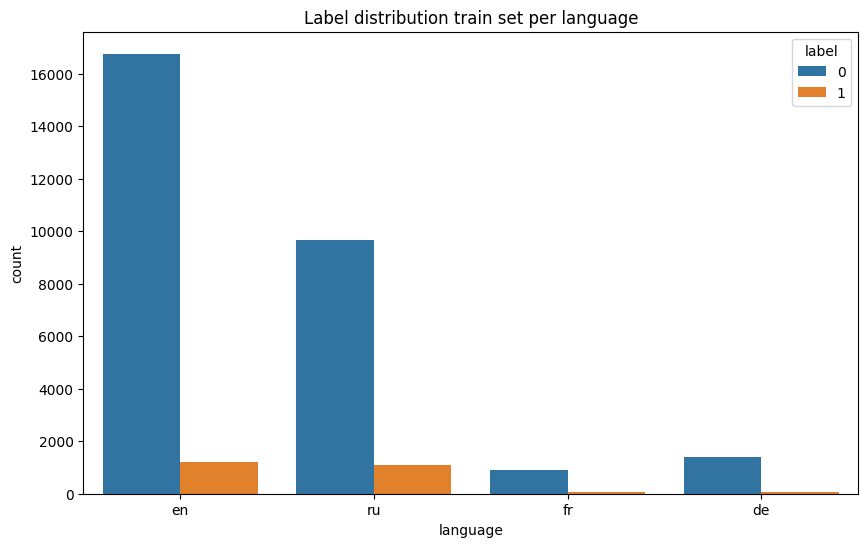

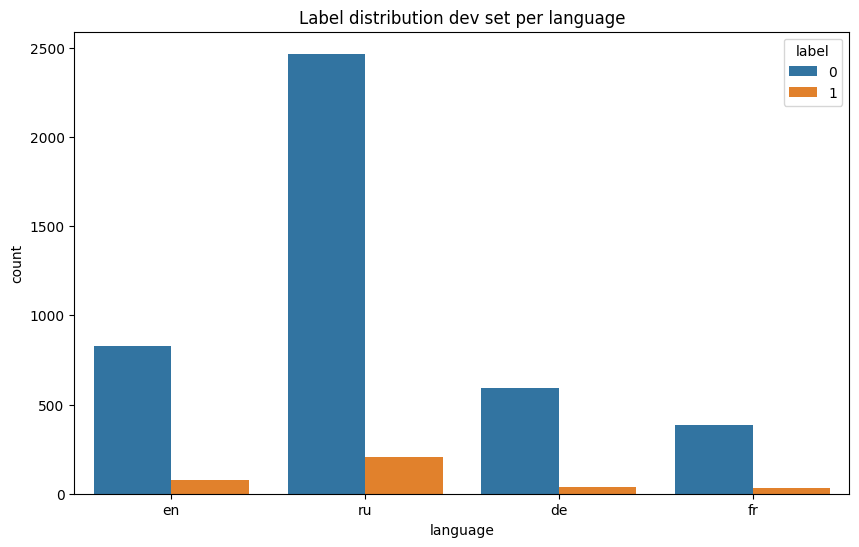

In [ ]:
# plot the label distribution for the training and development sets per language 
plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'], hue=train_data['label'])
plt.title("Label distribution train set per language")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'], hue=train_data['label'])
plt.title("Label distribution dev set per language")
plt.show()

## Length of Messages 

In [16]:
def compute_text_length(df):
    df['text_length'] = df['text'].str.split().str.len().fillna(0).astype(int)
    return df

train_data = compute_text_length(train_data)
dev_data = compute_text_length(dev_data)

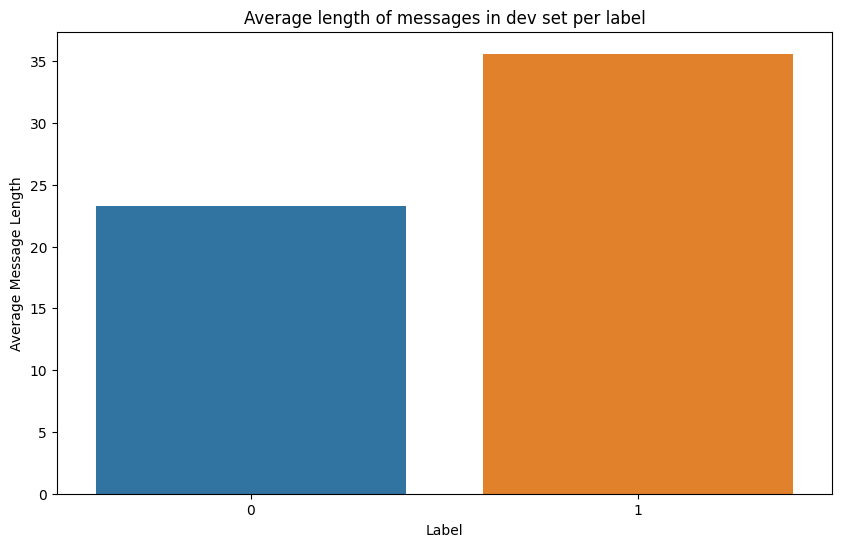

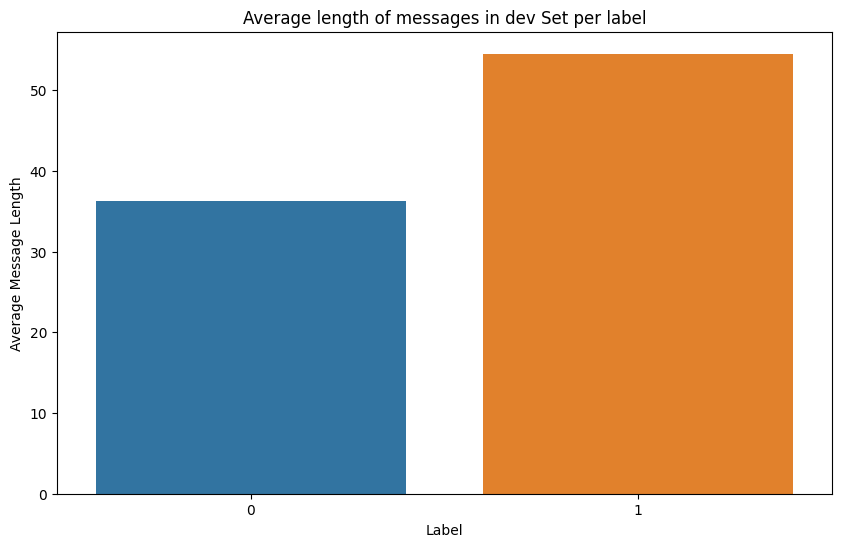

In [17]:
# plot the average length of messages across languages per train/dev set per label
plt.figure(figsize=(10,6))
sns.barplot(x=train_data['label'], y=train_data['text_length'], errorbar=None)
plt.title("Average length of messages in dev set per label")
plt.xlabel("Label")
plt.ylabel("Average Message Length")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=dev_data['label'], y=dev_data['text_length'], errorbar=None)
plt.title("Average length of messages in dev Set per label")
plt.xlabel("Label")
plt.ylabel("Average Message Length")
plt.show()


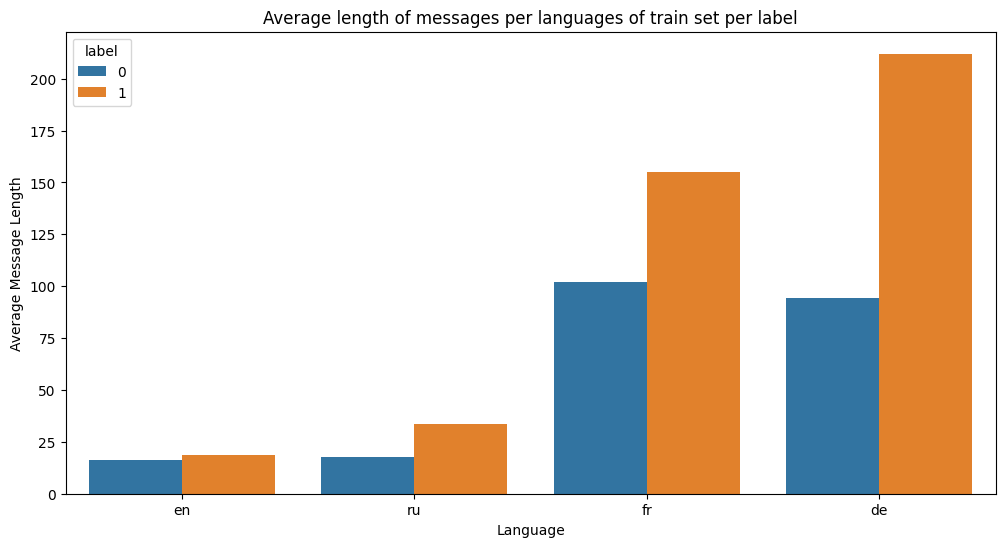

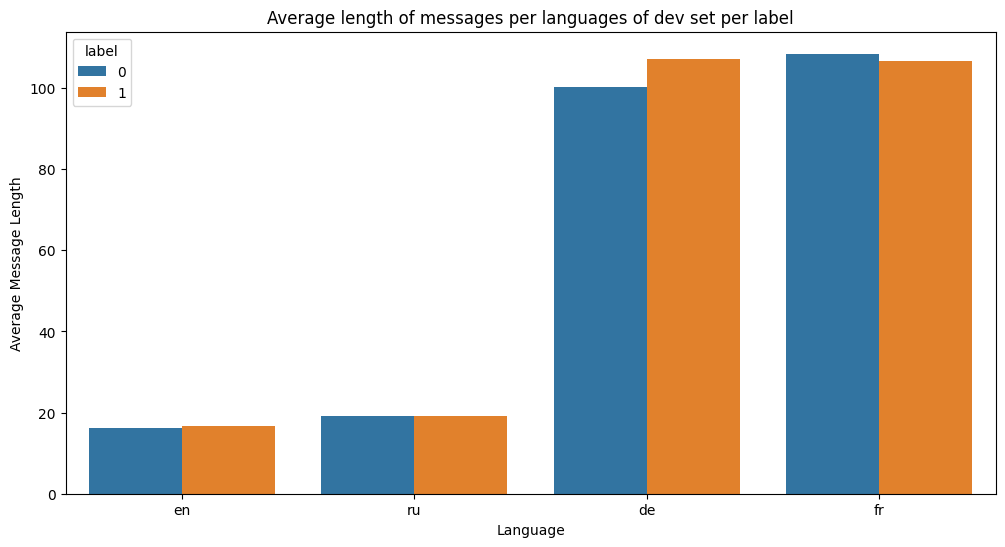

In [18]:
# plot the average length of messages per language per train/dev set per label
plt.figure(figsize=(12,6))
sns.barplot(x=train_data['language'], y=train_data['text_length'], hue=train_data['label'], errorbar=None)
plt.title("Average length of messages per languages of train set per label")
plt.xlabel("Language")
plt.ylabel("Average Message Length")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=dev_data['language'], y=dev_data['text_length'], hue=train_data['label'], errorbar=None)
plt.title("Average length of messages per languages of dev set per label")
plt.xlabel("Language")
plt.ylabel("Average Message Length")
plt.show()

# Inference

Here, we show how to load a fine-tuned (Hugginface) model (our baseline) and perform inference on the development set. 

In [ ]:
# The model should be saved after training with HuggingFace and must contain at least the following files in the directory:
# - config.json
# - model.safetensors (or pytorch_model.bin, depending on save format)
# - special_tokens_map.json
# - tokenizer_config.json
# - tokenizer.json

# Load dev data
dev_data = pd.read_csv("data/dev_data_SMM4H_2025_Task_1.csv")
print(f"Loaded test data with {len(dev_data)} rows.")

# Load the fine-tuned model and tokenizer
model_path = "seed_314/" 
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
print("Model and tokenizer loaded successfully.")

Loaded test data with 4625 rows.
Model and tokenizer loaded successfully.


In [ ]:
# Define batch size
batch_size = 32
predictions = []

start_time = time.time()
num_batches = len(range(0, len(dev_data), batch_size))

for i in tqdm(range(0, len(dev_data), batch_size), desc="Running Inference", unit="batch", total=num_batches):
    batch_texts = dev_data["text"][i:i+batch_size].tolist()
    print(f"Processing batch {i//batch_size + 1} with {len(batch_texts)} samples.")
    
    batch_encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt")

    # Run inference
    with torch.no_grad():
        outputs = model(**batch_encodings)

    # Get predictions for batch
    batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
    predictions.extend(batch_predictions)

end_time = time.time()
print(f"Total inference time: {end_time - start_time:.2f} seconds")

dev_data["predicted_label"] = predictions
print("Inference complete. Predictions stored in dataframe.")

Loaded test data with 4625 rows.


Running Inference:   0%|          | 0/145 [00:00<?, ?batch/s]

Processing batch 1 with 32 samples.


Running Inference:   1%|          | 1/145 [00:15<37:58, 15.82s/batch]

Processing batch 2 with 32 samples.


Running Inference:   1%|▏         | 2/145 [00:33<40:03, 16.81s/batch]

Processing batch 3 with 32 samples.


Running Inference:   2%|▏         | 3/145 [00:50<40:11, 16.98s/batch]

Processing batch 4 with 32 samples.


Running Inference:   3%|▎         | 4/145 [01:13<45:03, 19.17s/batch]

Processing batch 5 with 32 samples.


Running Inference:   3%|▎         | 5/145 [01:21<36:06, 15.47s/batch]

Processing batch 6 with 32 samples.


Running Inference:   4%|▍         | 6/145 [01:28<28:54, 12.48s/batch]

Processing batch 7 with 32 samples.


Running Inference:   5%|▍         | 7/145 [01:44<31:28, 13.68s/batch]

Processing batch 8 with 32 samples.


Running Inference:   6%|▌         | 8/145 [01:57<30:25, 13.32s/batch]

Processing batch 9 with 32 samples.


Running Inference:   6%|▌         | 9/145 [02:17<35:10, 15.52s/batch]

Processing batch 10 with 32 samples.


Running Inference:   7%|▋         | 10/145 [02:35<36:42, 16.32s/batch]

Processing batch 11 with 32 samples.


Running Inference:   8%|▊         | 11/145 [02:58<40:56, 18.33s/batch]

Processing batch 12 with 32 samples.


Running Inference:   8%|▊         | 12/145 [03:20<43:05, 19.44s/batch]

Processing batch 13 with 32 samples.


Running Inference:   9%|▉         | 13/145 [03:43<45:07, 20.51s/batch]

Processing batch 14 with 32 samples.


Running Inference:  10%|▉         | 14/145 [03:56<39:49, 18.24s/batch]

Processing batch 15 with 32 samples.


Running Inference:  10%|█         | 15/145 [04:09<35:43, 16.49s/batch]

Processing batch 16 with 32 samples.


Running Inference:  11%|█         | 16/145 [04:33<40:28, 18.83s/batch]

Processing batch 17 with 32 samples.


Running Inference:  12%|█▏        | 17/145 [04:41<33:35, 15.75s/batch]

Processing batch 18 with 32 samples.


Running Inference:  12%|█▏        | 18/145 [05:09<40:41, 19.22s/batch]

Processing batch 19 with 32 samples.


Running Inference:  13%|█▎        | 19/145 [05:30<41:22, 19.70s/batch]

Processing batch 20 with 32 samples.


Running Inference:  14%|█▍        | 20/145 [05:46<39:10, 18.81s/batch]

Processing batch 21 with 32 samples.


Running Inference:  14%|█▍        | 21/145 [06:13<43:43, 21.16s/batch]

Processing batch 22 with 32 samples.


Running Inference:  15%|█▌        | 22/145 [06:20<34:50, 16.99s/batch]

Processing batch 23 with 32 samples.


Running Inference:  16%|█▌        | 23/145 [06:43<37:52, 18.63s/batch]

Processing batch 24 with 32 samples.


Running Inference:  17%|█▋        | 24/145 [07:06<40:25, 20.05s/batch]

Processing batch 25 with 32 samples.


Running Inference:  17%|█▋        | 25/145 [07:26<39:56, 19.97s/batch]

Processing batch 26 with 32 samples.


Running Inference:  18%|█▊        | 26/145 [07:36<33:34, 16.93s/batch]

Processing batch 27 with 32 samples.


Running Inference:  19%|█▊        | 27/145 [08:08<42:14, 21.48s/batch]

Processing batch 28 with 32 samples.


Running Inference:  19%|█▉        | 28/145 [08:20<36:34, 18.76s/batch]

Processing batch 29 with 32 samples.


Running Inference:  20%|██        | 29/145 [08:28<30:06, 15.57s/batch]

Processing batch 30 with 32 samples.


Running Inference:  21%|██        | 30/145 [08:41<28:03, 14.64s/batch]

Processing batch 31 with 32 samples.


Running Inference:  21%|██▏       | 31/145 [09:10<36:05, 18.99s/batch]

Processing batch 32 with 32 samples.


Running Inference:  22%|██▏       | 32/145 [09:22<31:50, 16.91s/batch]

Processing batch 33 with 32 samples.


Running Inference:  23%|██▎       | 33/145 [09:39<31:24, 16.83s/batch]

Processing batch 34 with 32 samples.


Running Inference:  23%|██▎       | 34/145 [09:44<24:59, 13.51s/batch]

Processing batch 35 with 32 samples.


Running Inference:  24%|██▍       | 35/145 [09:55<23:16, 12.69s/batch]

Processing batch 36 with 32 samples.


Running Inference:  25%|██▍       | 36/145 [10:02<20:08, 11.09s/batch]

Processing batch 37 with 32 samples.


Running Inference:  26%|██▌       | 37/145 [10:16<21:23, 11.88s/batch]

Processing batch 38 with 32 samples.


Running Inference:  26%|██▌       | 38/145 [10:27<20:49, 11.68s/batch]

Processing batch 39 with 32 samples.


Running Inference:  27%|██▋       | 39/145 [10:34<18:10, 10.28s/batch]

Processing batch 40 with 32 samples.


Running Inference:  28%|██▊       | 40/145 [10:38<14:35,  8.34s/batch]

Processing batch 41 with 32 samples.


Running Inference:  28%|██▊       | 41/145 [11:06<24:41, 14.24s/batch]

Processing batch 42 with 32 samples.


Running Inference:  29%|██▉       | 42/145 [11:23<25:40, 14.96s/batch]

Processing batch 43 with 32 samples.


Running Inference:  30%|██▉       | 43/145 [11:28<20:18, 11.94s/batch]

Processing batch 44 with 32 samples.


Running Inference:  30%|███       | 44/145 [11:35<17:44, 10.54s/batch]

Processing batch 45 with 32 samples.


Running Inference:  31%|███       | 45/145 [11:48<19:01, 11.42s/batch]

Processing batch 46 with 32 samples.


Running Inference:  32%|███▏      | 46/145 [11:58<17:44, 10.75s/batch]

Processing batch 47 with 32 samples.


Running Inference:  32%|███▏      | 47/145 [12:04<15:33,  9.53s/batch]

Processing batch 48 with 32 samples.


Running Inference:  33%|███▎      | 48/145 [12:15<15:44,  9.73s/batch]

Processing batch 49 with 32 samples.


Running Inference:  34%|███▍      | 49/145 [12:22<14:21,  8.98s/batch]

Processing batch 50 with 32 samples.


Running Inference:  34%|███▍      | 50/145 [12:29<13:12,  8.34s/batch]

Processing batch 51 with 32 samples.


Running Inference:  35%|███▌      | 51/145 [12:47<17:51, 11.40s/batch]

Processing batch 52 with 32 samples.


Running Inference:  36%|███▌      | 52/145 [12:58<17:11, 11.09s/batch]

Processing batch 53 with 32 samples.


Running Inference:  37%|███▋      | 53/145 [13:04<14:55,  9.74s/batch]

Processing batch 54 with 32 samples.


Running Inference:  37%|███▋      | 54/145 [13:29<21:31, 14.20s/batch]

Processing batch 55 with 32 samples.


Running Inference:  38%|███▊      | 55/145 [13:52<25:21, 16.91s/batch]

Processing batch 56 with 32 samples.


Running Inference:  39%|███▊      | 56/145 [14:12<26:17, 17.73s/batch]

Processing batch 57 with 32 samples.


Running Inference:  39%|███▉      | 57/145 [14:22<22:59, 15.67s/batch]

Processing batch 58 with 32 samples.


Running Inference:  40%|████      | 58/145 [14:46<26:17, 18.13s/batch]

Processing batch 59 with 32 samples.


Running Inference:  41%|████      | 59/145 [14:56<22:30, 15.70s/batch]

Processing batch 60 with 32 samples.


Running Inference:  41%|████▏     | 60/145 [15:05<19:11, 13.55s/batch]

Processing batch 61 with 32 samples.


Running Inference:  42%|████▏     | 61/145 [15:24<21:22, 15.27s/batch]

Processing batch 62 with 32 samples.


Running Inference:  43%|████▎     | 62/145 [15:36<19:33, 14.13s/batch]

Processing batch 63 with 32 samples.


Running Inference:  43%|████▎     | 63/145 [15:49<19:00, 13.90s/batch]

Processing batch 64 with 32 samples.


Running Inference:  44%|████▍     | 64/145 [16:02<18:35, 13.77s/batch]

Processing batch 65 with 32 samples.


Running Inference:  45%|████▍     | 65/145 [16:20<19:40, 14.76s/batch]

Processing batch 66 with 32 samples.


Running Inference:  46%|████▌     | 66/145 [16:30<17:50, 13.55s/batch]

Processing batch 67 with 32 samples.


Running Inference:  46%|████▌     | 67/145 [16:49<19:30, 15.01s/batch]

Processing batch 68 with 32 samples.


Running Inference:  47%|████▋     | 68/145 [17:13<22:45, 17.73s/batch]

Processing batch 69 with 32 samples.


Running Inference:  48%|████▊     | 69/145 [17:37<24:47, 19.58s/batch]

Processing batch 70 with 32 samples.


Running Inference:  48%|████▊     | 70/145 [18:01<26:18, 21.04s/batch]

Processing batch 71 with 32 samples.


Running Inference:  49%|████▉     | 71/145 [18:14<22:50, 18.53s/batch]

Processing batch 72 with 32 samples.


Running Inference:  50%|████▉     | 72/145 [18:38<24:41, 20.29s/batch]

Processing batch 73 with 32 samples.


Running Inference:  50%|█████     | 73/145 [18:52<22:00, 18.34s/batch]

Processing batch 74 with 32 samples.


Running Inference:  51%|█████     | 74/145 [19:10<21:32, 18.21s/batch]

Processing batch 75 with 32 samples.


Running Inference:  52%|█████▏    | 75/145 [19:21<18:34, 15.92s/batch]

Processing batch 76 with 32 samples.


Running Inference:  52%|█████▏    | 76/145 [19:32<16:49, 14.63s/batch]

Processing batch 77 with 32 samples.


Running Inference:  53%|█████▎    | 77/145 [19:43<15:25, 13.61s/batch]

Processing batch 78 with 32 samples.


Running Inference:  54%|█████▍    | 78/145 [19:52<13:24, 12.01s/batch]

Processing batch 79 with 32 samples.


Running Inference:  54%|█████▍    | 79/145 [20:16<17:17, 15.72s/batch]

Processing batch 80 with 32 samples.


Running Inference:  55%|█████▌    | 80/145 [20:39<19:30, 18.01s/batch]

Processing batch 81 with 32 samples.


Running Inference:  56%|█████▌    | 81/145 [20:51<17:13, 16.14s/batch]

Processing batch 82 with 32 samples.


Running Inference:  57%|█████▋    | 82/145 [21:15<19:32, 18.61s/batch]

Processing batch 83 with 32 samples.


Running Inference:  57%|█████▋    | 83/145 [21:23<15:38, 15.13s/batch]

Processing batch 84 with 32 samples.


Running Inference:  58%|█████▊    | 84/145 [21:47<18:19, 18.03s/batch]

Processing batch 85 with 32 samples.


Running Inference:  59%|█████▊    | 85/145 [22:00<16:17, 16.29s/batch]

Processing batch 86 with 32 samples.


Running Inference:  59%|█████▉    | 86/145 [22:07<13:24, 13.64s/batch]

Processing batch 87 with 32 samples.


Running Inference:  60%|██████    | 87/145 [22:22<13:38, 14.11s/batch]

Processing batch 88 with 32 samples.


Running Inference:  61%|██████    | 88/145 [22:37<13:29, 14.20s/batch]

Processing batch 89 with 32 samples.


Running Inference:  61%|██████▏   | 89/145 [22:50<12:56, 13.86s/batch]

Processing batch 90 with 32 samples.


Running Inference:  62%|██████▏   | 90/145 [23:02<12:20, 13.46s/batch]

Processing batch 91 with 32 samples.


Running Inference:  63%|██████▎   | 91/145 [23:09<10:10, 11.31s/batch]

Processing batch 92 with 32 samples.


Running Inference:  63%|██████▎   | 92/145 [23:23<10:56, 12.39s/batch]

Processing batch 93 with 32 samples.


Running Inference:  64%|██████▍   | 93/145 [23:34<10:20, 11.93s/batch]

Processing batch 94 with 32 samples.


Running Inference:  65%|██████▍   | 94/145 [23:41<08:55, 10.49s/batch]

Processing batch 95 with 32 samples.


Running Inference:  66%|██████▌   | 95/145 [23:56<09:53, 11.86s/batch]

Processing batch 96 with 32 samples.


Running Inference:  66%|██████▌   | 96/145 [24:21<12:54, 15.81s/batch]

Processing batch 97 with 32 samples.


Running Inference:  67%|██████▋   | 97/145 [24:29<10:37, 13.28s/batch]

Processing batch 98 with 32 samples.


Running Inference:  68%|██████▊   | 98/145 [24:40<10:00, 12.77s/batch]

Processing batch 99 with 32 samples.


Running Inference:  68%|██████▊   | 99/145 [25:04<12:14, 15.98s/batch]

Processing batch 100 with 32 samples.


Running Inference:  69%|██████▉   | 100/145 [25:24<12:58, 17.29s/batch]

Processing batch 101 with 32 samples.


Running Inference:  70%|██████▉   | 101/145 [25:32<10:40, 14.56s/batch]

Processing batch 102 with 32 samples.


Running Inference:  70%|███████   | 102/145 [25:41<09:05, 12.68s/batch]

Processing batch 103 with 32 samples.


Running Inference:  71%|███████   | 103/145 [25:49<07:56, 11.34s/batch]

Processing batch 104 with 32 samples.


Running Inference:  72%|███████▏  | 104/145 [26:01<07:57, 11.66s/batch]

Processing batch 105 with 32 samples.


Running Inference:  72%|███████▏  | 105/145 [26:20<09:13, 13.83s/batch]

Processing batch 106 with 32 samples.


Running Inference:  73%|███████▎  | 106/145 [26:44<11:01, 16.95s/batch]

Processing batch 107 with 32 samples.


Running Inference:  74%|███████▍  | 107/145 [27:04<11:10, 17.66s/batch]

Processing batch 108 with 32 samples.


Running Inference:  74%|███████▍  | 108/145 [27:15<09:44, 15.81s/batch]

Processing batch 109 with 32 samples.


Running Inference:  75%|███████▌  | 109/145 [27:39<10:52, 18.12s/batch]

Processing batch 110 with 32 samples.


Running Inference:  76%|███████▌  | 110/145 [27:57<10:39, 18.27s/batch]

Processing batch 111 with 32 samples.


Running Inference:  77%|███████▋  | 111/145 [28:05<08:36, 15.20s/batch]

Processing batch 112 with 32 samples.


Running Inference:  77%|███████▋  | 112/145 [28:12<06:52, 12.51s/batch]

Processing batch 113 with 32 samples.


Running Inference:  78%|███████▊  | 113/145 [28:28<07:14, 13.59s/batch]

Processing batch 114 with 32 samples.


Running Inference:  79%|███████▊  | 114/145 [28:38<06:32, 12.65s/batch]

Processing batch 115 with 32 samples.


Running Inference:  79%|███████▉  | 115/145 [28:51<06:16, 12.56s/batch]

Processing batch 116 with 32 samples.


Running Inference:  80%|████████  | 116/145 [29:05<06:22, 13.18s/batch]

Processing batch 117 with 32 samples.


Running Inference:  81%|████████  | 117/145 [29:30<07:49, 16.77s/batch]

Processing batch 118 with 32 samples.


Running Inference:  81%|████████▏ | 118/145 [29:39<06:23, 14.22s/batch]

Processing batch 119 with 32 samples.


Running Inference:  82%|████████▏ | 119/145 [29:42<04:44, 10.95s/batch]

Processing batch 120 with 32 samples.


Running Inference:  83%|████████▎ | 120/145 [29:52<04:26, 10.66s/batch]

Processing batch 121 with 32 samples.


Running Inference:  83%|████████▎ | 121/145 [30:14<05:36, 14.01s/batch]

Processing batch 122 with 32 samples.


Running Inference:  84%|████████▍ | 122/145 [30:29<05:32, 14.45s/batch]

Processing batch 123 with 32 samples.


Running Inference:  85%|████████▍ | 123/145 [30:54<06:23, 17.42s/batch]

Processing batch 124 with 32 samples.


Running Inference:  86%|████████▌ | 124/145 [31:17<06:45, 19.33s/batch]

Processing batch 125 with 32 samples.


Running Inference:  86%|████████▌ | 125/145 [31:35<06:13, 18.67s/batch]

Processing batch 126 with 32 samples.


Running Inference:  87%|████████▋ | 126/145 [31:59<06:28, 20.47s/batch]

Processing batch 127 with 32 samples.


Running Inference:  88%|████████▊ | 127/145 [32:18<06:01, 20.10s/batch]

Processing batch 128 with 32 samples.


Running Inference:  88%|████████▊ | 128/145 [32:29<04:52, 17.20s/batch]

Processing batch 129 with 32 samples.


Running Inference:  89%|████████▉ | 129/145 [32:44<04:27, 16.72s/batch]

Processing batch 130 with 32 samples.


Running Inference:  90%|████████▉ | 130/145 [33:07<04:38, 18.57s/batch]

Processing batch 131 with 32 samples.


Running Inference:  90%|█████████ | 131/145 [33:31<04:40, 20.05s/batch]

Processing batch 132 with 32 samples.


Running Inference:  91%|█████████ | 132/145 [33:41<03:43, 17.21s/batch]

Processing batch 133 with 32 samples.


Running Inference:  92%|█████████▏| 133/145 [33:57<03:21, 16.76s/batch]

Processing batch 134 with 32 samples.


Running Inference:  92%|█████████▏| 134/145 [34:04<02:32, 13.85s/batch]

Processing batch 135 with 32 samples.


Running Inference:  93%|█████████▎| 135/145 [34:29<02:51, 17.11s/batch]

Processing batch 136 with 32 samples.


Running Inference:  94%|█████████▍| 136/145 [34:35<02:05, 13.96s/batch]

Processing batch 137 with 32 samples.


Running Inference:  94%|█████████▍| 137/145 [34:48<01:47, 13.44s/batch]

Processing batch 138 with 32 samples.


Running Inference:  95%|█████████▌| 138/145 [34:55<01:21, 11.69s/batch]

Processing batch 139 with 32 samples.


Running Inference:  96%|█████████▌| 139/145 [35:01<00:58,  9.74s/batch]

Processing batch 140 with 32 samples.


Running Inference:  97%|█████████▋| 140/145 [35:12<00:51, 10.30s/batch]

Processing batch 141 with 32 samples.


Running Inference:  97%|█████████▋| 141/145 [35:16<00:33,  8.43s/batch]

Processing batch 142 with 32 samples.


Running Inference:  98%|█████████▊| 142/145 [35:23<00:23,  7.96s/batch]

Processing batch 143 with 32 samples.


Running Inference:  99%|█████████▊| 143/145 [35:31<00:16,  8.02s/batch]

Processing batch 144 with 32 samples.


Running Inference:  99%|█████████▉| 144/145 [35:55<00:12, 12.63s/batch]

Processing batch 145 with 17 samples.


Running Inference: 100%|██████████| 145/145 [35:57<00:00, 14.88s/batch]

Total inference time: 2157.30 seconds
Inference complete. Predictions stored in dataframe.
Predictions saved to predictions.csv.
Sample predictions:
                                                text  predicted_label
0  DO U ALWAYS TAKE UR MEDS ON TIME? DO U EVER ST...                0
1  Этот противовирусный препарат очень уменьшает ...                0
2  @USER_ @USER___ just spoke to one source:  Gre...                0
3            Ещё один день начался не с ксанакса (((                0
4  @USER__ too bad buddy, Pfizer needs to sell so...                0


In [ ]:
# Show some examples of predictions
print("Sample predictions:")
print(dev_data[["id", "predicted_label"]].head())

         id  predicted_label
0    en_212                0
1   ru_4003                0
2    en_589                0
3  ru_10539                0
4     en_77                0


In [ ]:
# Save predictions to CSV
dev_data[["id", "predicted_label"]].to_csv("predictions.csv", index=False)

# zip the predictions file for CodaLab
zip_filename = "predictions.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("predictions.csv")
print(f"Predictions saved and zipped as {zip_filename}")

Predictions saved and zipped as predictions.zip


# Evaluation

This is for showcasing how to evaluate the predictions using the same evaluation as on CodaLab. The predictions need to be stored in a CSV file and uploaded to CodaLab. Submissions will be ranked by non-weighted macro F1-score *across languages*. 

In [ ]:
zip_filename = "predictions.zip"
if not os.path.exists(zip_filename):
    raise FileNotFoundError("Predictions ZIP file not found. Run inference and/or zipping first.")

# Unzip the predictions file
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extractall("./")
    print("Predictions file extracted successfully.")

# Load the prediction data
pred_data = pd.read_csv("predictions.csv")

Predictions file extracted successfully.


In [ ]:
def evaluate(gold_df, predictions):
    """Calculate and print accuracy, precision, recall, and F1-score based on the gold standard and predictions."""
    goldstandard = gold_df.set_index('id')['label'].to_dict()  
    predictions = predictions.set_index('id')['predicted_label'].to_dict()  
    languages = gold_df.set_index('id')['language'].to_dict()
    
    all_y_true = []
    all_y_pred = []
    results = []
    f1_scores = []
    scores_data = []  

    for lang in set(languages.values()):
        lang_ids = [i for i in goldstandard.keys() if languages[i] == lang]
        y_true = [goldstandard[i] for i in lang_ids if i in predictions]
        y_pred = [predictions[i] for i in lang_ids if i in predictions]

        if y_true and y_pred:
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
            accuracy = accuracy_score(y_true, y_pred)  
            results.append(f'Precision-{lang}: {precision:.4f}\nRecall-{lang}: {recall:.4f}\nF1-{lang}: {f1:.4f}\nAccuracy-{lang}: {accuracy:.4f}\n')
            f1_scores.append(f1) 
            scores_data.append([lang, precision, recall, f1, accuracy])

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    # Compute F1-scores across languages
    macro_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
    f1_across_languages = f1_score(all_y_true, all_y_pred, average='binary')  # F1 for all data
    results.append(f'F1-score across all languages: {f1_across_languages:.4f}')
    overall_accuracy = accuracy_score(all_y_true, all_y_pred) if all_y_true and all_y_pred else 0.0
    results.append(f'Macro F1-score across all languages: {macro_f1:.4f}')
    results.append(f'Overall Accuracy: {overall_accuracy:.4f}')

    print("\n".join(results))
    return pd.DataFrame(scores_data, columns=["Language", "Precision", "Recall", "F1-Score", "Accuracy"])

Precision-de: 0.6897
Recall-de: 0.5714
F1-de: 0.6250
Accuracy-de: 0.9621

Precision-en: 0.6984
Recall-en: 0.7213
F1-en: 0.7097
Accuracy-en: 0.9601

Precision-ru: 0.7208
Recall-ru: 0.7022
F1-ru: 0.7114
Accuracy-ru: 0.9419

Precision-fr: 0.7097
Recall-fr: 0.7333
F1-fr: 0.7213
Accuracy-fr: 0.9594

F1-score across all languages: 0.7048
Macro F1-score across all languages: 0.6918
Overall Accuracy: 0.9498


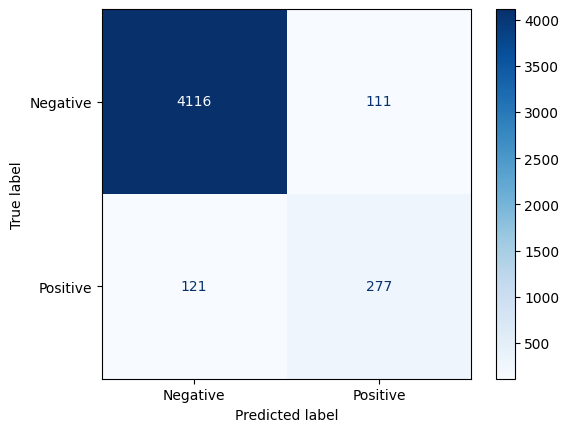

In [ ]:
# show the resulting scores and a confusion matrix
scores_df = evaluate(dev_data, pred_data)

true_labels_list = dev_data.loc[dev_data['id'].isin(pred_data['id']), 'label'].tolist()
pred_labels_list = pred_data.loc[pred_data['id'].isin(dev_data['id']), 'predicted_label'].tolist()
cm = confusion_matrix(true_labels_list, pred_labels_list, labels=[0, 1])
labels = ["Negative", "Positive"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.show()

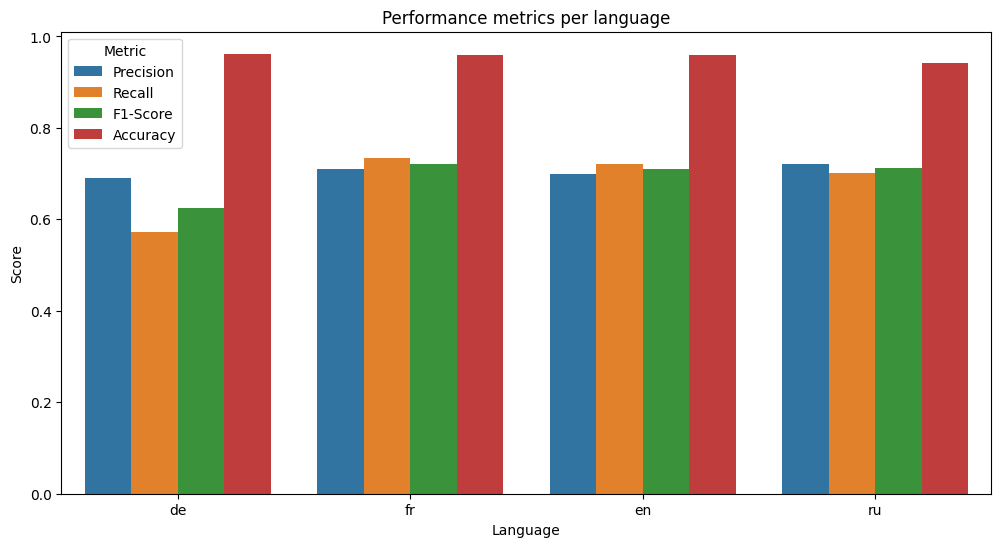

In [63]:
# Plot the scores per language and per label
plt.figure(figsize=(12,6))
scores_df_melted = scores_df.melt(id_vars=["Language"], value_vars=["Precision", "Recall", "F1-Score", "Accuracy"], var_name="Metric", value_name="Score")
sns.barplot(x="Language", y="Score", hue="Metric", data=scores_df_melted)
plt.title("Performance metrics per language")
plt.xlabel("Language")
plt.ylabel("Score")
plt.legend(title="Metric")
plt.show()